### Import dependencies and define functions:

In [1]:
## region Import Dependencies:

# For data processing & plotting:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy
from scipy.signal import detrend

# For ML:
import time as timer  # for timing code cells.
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector  # For sequential feature sel.
from sklearn.model_selection import GridSearchCV  # To do parameter search
from sklearn import metrics
from sklearn.pipeline import make_pipeline  # for grid-search over parameters pipeline.

# Classifiers for CPU based computing:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron


# Only for GPU based computing:
# from cuml.svm import SVC
# from cuml.neighbors import KNeighborsClassifier
# from cuml.ensemble import RandomForestClassifier
# from cuml.linear_model import LogisticRegression

# Define function to normalize:
def normalize(x):
    """
    Function to normalize using: X_n = ( X - X_min ) / ( X_max - X_min). Results in data in [0,1]
    :param x: Unormalized data
    :return: Normalized data
    """
    x_n = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x_n


# Define function to partition into windows and calculate window-wise metrics
def window_partition(data, n_channels, window_size, overlap):
    """
    Function to partition concatenated data into windows and perform various window wise metrics
    :param data: PD Dataframe with LABELED and normalized (if needed) concatenated data
    :param n_channels: 1=Only first channel, 2=only second channel, 3=both channels
    :param window_size: Window size
    :param overlap: Window overlap
    :return: PD Dataframe of metrics for input to ML model along with labels.
    """

    # Partition data:
    step_size = window_size - overlap
    # Initialize list to place windows:
    window_list = [[] for i in range(2)]
    window_list_fft = [[] for i in range(2)]
    # Initialize list to place labels:
    label_list = []

    # Do partitioning:
    for i in range(0, len(data), step_size):
        xs = data['Data ch1'].values[i:i + window_size]
        xs_2 = data['Data ch2'].values[i:i + window_size]
        lab = stats.mode(data['Labels'].values[i:i + window_size])[0][0]

        window_list[0].append(xs)  # Store windows from ch 1
        window_list[1].append(xs_2)  # Store windows from ch 2
        label_list.append(lab)  # Store labels

    # Subtract mean to reduce drift artifact:
    # window_list_cent = [[],[]]
    # for i in range(len(window_list[0])):
    #    window_list_cent[0].append(window_list[0][i] - np.mean(window_list[0][i]))
    #    window_list_cent[1].append(window_list[1][i] - np.mean(window_list[1][i]

    # Initialize dataframe:
    X = pd.DataFrame()

    # Statistical Features on signal in time domain for channel 1:
    if n_channels == 1 or n_channels == 3:
        # mean
        X['x_mean'] = pd.Series(window_list[0]).apply(lambda x: x.mean())
        # std dev
        X['x_std'] = pd.Series(window_list[0]).apply(lambda x: x.std())
        # min
        X['x_min'] = pd.Series(window_list[0]).apply(lambda x: x.min())
        # max
        X['x_max'] = pd.Series(window_list[0]).apply(lambda x: x.max())
        # median
        X['x_median'] = pd.Series(window_list[0]).apply(lambda x: np.median(x))
        # number of peaks
        X['x_peak_count'] = pd.Series(window_list[0]).apply(lambda x: len(find_peaks(x)[0]))
        # skewness
        X['x_skewness'] = pd.Series(window_list[0]).apply(lambda x: stats.skew(x))
        # kurtosis
        X['x_kurtosis'] = pd.Series(window_list[0]).apply(lambda x: stats.kurtosis(x))
        # energy
        X['x_energy'] = pd.Series(window_list[0]).apply(lambda x: np.sum(x ** 2) / 100)
        # rms
        X['x_rms'] = pd.Series(window_list[0]).apply(lambda x: np.sqrt(np.mean(x ** 2)))

        # Statistical Features on signal in freq domain:
        lim = int(window_size / 2)  # Take only half of the spectrum since symmetric.
        window_list_fft[0] = pd.Series(window_list[0]).apply(lambda x: np.abs(np.fft.fft(x))[0:lim])

        # Mean
        X['x_mean_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: np.mean(x))
        # Max Freq Index
        X['x_max_freq_idx'] = pd.Series(window_list_fft[0]).apply(lambda x: np.argmax(x))
        # Min Freq Index [Ignore first entry since close to zero]
        X['x_min_freq_idx'] = pd.Series(window_list_fft[0]).apply(lambda x: np.argmin(x[1:]))
        # Entropy
        X['x_entr_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: entropy(x))
        # std dev
        X['x_std_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: x.std())
        # min [ignore zeros]
        X['x_min_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: np.min(x[np.nonzero(x)]))
        # max
        X['x_max_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: x.max())
        # median
        X['x_median_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: np.median(x))
        # number of peaks
        X['x_peak_count_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: len(find_peaks(x)[0]))
        # skewness
        X['x_skewness_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: stats.skew(x))
        # kurtosis
        X['x_kurtosis_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: stats.kurtosis(x))
        # energy
        X['x_energy_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: np.sum(x ** 2) / 100)

    if n_channels == 2 or n_channels == 3:
        # mean
        X['x_mean_2'] = pd.Series(window_list[1]).apply(lambda x: x.mean())
        X['x_std_2'] = pd.Series(window_list[1]).apply(lambda x: x.std())
        X['x_min_2'] = pd.Series(window_list[1]).apply(lambda x: x.min())
        X['x_max_2'] = pd.Series(window_list[1]).apply(lambda x: x.max())
        X['x_median_2'] = pd.Series(window_list[1]).apply(lambda x: np.median(x))
        X['x_peak_count_2'] = pd.Series(window_list[1]).apply(lambda x: len(find_peaks(x)[0]))
        X['x_skewness_2'] = pd.Series(window_list[1]).apply(lambda x: stats.skew(x))
        X['x_kurtosis_2'] = pd.Series(window_list[1]).apply(lambda x: stats.kurtosis(x))
        X['x_energy_2'] = pd.Series(window_list[1]).apply(lambda x: np.sum(x ** 2) / 100)
        X['x_rms_2'] = pd.Series(window_list[1]).apply(lambda x: np.sqrt(np.mean(x ** 2)))

        # Statistical Features on signal in freq domain:
        lim = int(window_size / 2)
        window_list_fft[1] = pd.Series(window_list[1]).apply(lambda x: np.abs(np.fft.fft(x))[0:lim])

        X['x_mean_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.mean(x))
        X['x_max_freq_idx_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.argmax(x))
        X['x_min_freq_idx_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.argmin(x[1:]))
        X['x_entr_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: entropy(x))
        X['x_std_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: x.std())
        X['x_min_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.min(x[np.nonzero(x)]))
        X['x_max_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: x.max())
        X['x_median_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.median(x))
        X['x_peak_count_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: len(find_peaks(x)[0]))
        X['x_skewness_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: stats.skew(x))
        X['x_kurtosis_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: stats.kurtosis(x))
        X['x_energy_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.sum(x ** 2) / 100)

    label_list = pd.Series(label_list)

    return X, label_list


# endregion

### Load data:

In [2]:
## region Load data:
s1_1 = pd.read_csv('data/11.csv', header=None)  # first subject, sensor 1
ch1 = s1_1.iloc[:, 1]
ch2 = s1_1.iloc[:, 2]
r1_1_ch1 = (-ch1 * 100) / (ch1 - 1)  # channel one (normal breathing)
r1_1_ch2 = (-ch2 * 100) / (ch2 - 1)  # channel two (normal breathing)

time = np.arange(0, .015 * len(r1_1_ch1), .015)  # 15 ms per time-point

s1_2 = pd.read_csv('data/12.csv', header=None)  # first subject, second trial
ch1 = s1_2.iloc[:, 1]
ch2 = s1_2.iloc[:, 2]
r1_2_ch1 = (-ch1 * 100) / (ch1 - 1)  # channel one (coughing)
r1_2_ch2 = (-ch2 * 100) / (ch2 - 1)  # channel two (coughing)

s2_1 = pd.read_csv('data/21.csv', header=None)
ch1 = s2_1.iloc[:, 1]
ch2 = s2_1.iloc[:, 2]
r2_1_ch1 = (-ch1 * 100) / (ch1 - 1)
r2_1_ch2 = (-ch2 * 100) / (ch2 - 1)

s2_2 = pd.read_csv('data/22.csv', header=None)
ch1 = s2_2.iloc[:, 1]
ch2 = s2_2.iloc[:, 2]
r2_2_ch1 = (-ch1 * 100) / (ch1 - 1)
r2_2_ch2 = (-ch2 * 100) / (ch2 - 1)

s3_1 = pd.read_csv('data/41.csv', header=None)
ch1 = s3_1.iloc[:, 1]
ch2 = s3_1.iloc[:, 2]
r3_1_ch1 = (-ch1 * 100) / (ch1 - 1)
r3_1_ch2 = (-ch2 * 100) / (ch2 - 1)

s3_2 = pd.read_csv('data/42.csv', header=None)
ch1 = s3_2.iloc[:, 1]
ch2 = s3_2.iloc[:, 2]
r3_2_ch1 = (-ch1 * 100) / (ch1 - 1)
r3_2_ch2 = (-ch2 * 100) / (ch2 - 1)
# endregion

### Normalize and detrend data.
##### Detrending subtracts the best fit line to remove any sensor drift

In [3]:
##  region normalize and detrend data:
r1_1_ch1 = pd.Series(normalize(detrend(r1_1_ch1)))
r1_1_ch2 = pd.Series(normalize(detrend(r1_1_ch2)))
r1_2_ch1 = pd.Series(normalize(detrend(r1_2_ch1)))
r1_2_ch2 = pd.Series(normalize(detrend(r1_2_ch2)))

r2_1_ch1 = pd.Series(normalize(detrend(r2_1_ch1)))
r2_1_ch2 = pd.Series(normalize(detrend(r2_1_ch2)))
r2_2_ch1 = pd.Series(normalize(detrend(r2_2_ch1)))
r2_2_ch2 = pd.Series(normalize(detrend(r2_2_ch2)))

r3_1_ch1 = pd.Series(normalize(detrend(r3_1_ch1)))
r3_1_ch2 = pd.Series(normalize(detrend(r3_1_ch2)))
r3_2_ch1 = pd.Series(normalize(detrend(r3_2_ch1)))
r3_2_ch2 = pd.Series(normalize(detrend(r3_2_ch2)))

# endregion

### Plot data. As can be seen, the data is normalized and de-trended.

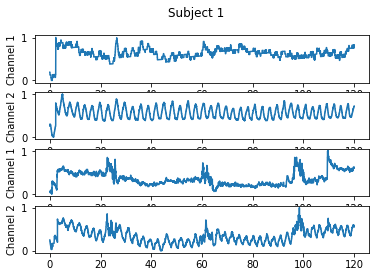

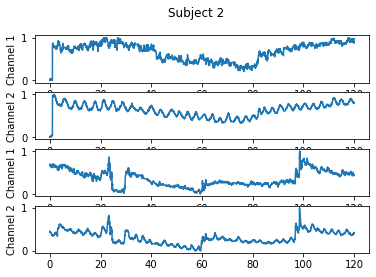

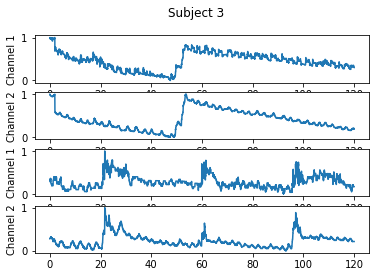

In [4]:
## region Plot data:
fig, axs = plt.subplots(4, 1)
fig.suptitle('Subject 1')
axs[0].plot(time, r1_1_ch1)
axs[0].set_ylabel("Channel 1")
axs[1].plot(time, r1_1_ch2)
axs[1].set_ylabel("Channel 2")
axs[2].plot(time, r1_2_ch1)
axs[2].set_ylabel("Channel 1")
axs[3].plot(time, r1_2_ch2)
axs[3].set_ylabel("Channel 2")
plt.show()

fig, axs = plt.subplots(4, 1)
fig.suptitle('Subject 2')
axs[0].plot(time, r2_1_ch1)
axs[0].set_ylabel("Channel 1")
axs[1].plot(time, r2_1_ch2)
axs[1].set_ylabel("Channel 2")
axs[2].plot(time, r2_2_ch1)
axs[2].set_ylabel("Channel 1")
axs[3].plot(time, r2_2_ch2)
axs[3].set_ylabel("Channel 2")
plt.show()

fig, axs = plt.subplots(4, 1)
fig.suptitle('Subject 3')
axs[0].plot(time, r3_1_ch1)
axs[0].set_ylabel("Channel 1")
axs[1].plot(time, r3_1_ch2)
axs[1].set_ylabel("Channel 2")
axs[2].plot(time, r3_2_ch1)
axs[2].set_ylabel("Channel 1")
axs[3].plot(time, r3_2_ch2)
axs[3].set_ylabel("Channel 2")
plt.show()

# endregion

### Create and plot labels for coughing and no coughing events:

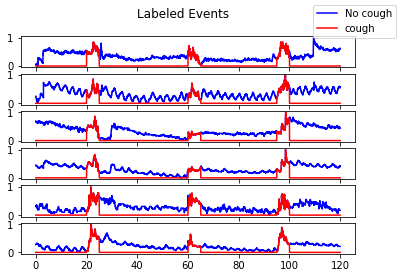

In [15]:
## region Create labels for coughing events at 20-25, 60-65, and 95-100 seconds.
label1 = (time > 20) * (time < 25)
label2 = (time > 60) * (time < 65)
label3 = (time > 95) * (time < 100)
label_c = label1 + label2 + label3
label_c = np.int32(label_c)
# Turn into Dataframe
label_c = pd.DataFrame(label_c)
label_c = label_c.iloc[:, 0]

# Label for channels with no coughing (all 0's):
label_nc = np.zeros(len(label_c))
label_nc = pd.DataFrame(label_nc)
label_nc = label_nc.iloc[:, 0]

# Plot subjects with red labeled as cough:
labels = ['r1_2_ch1', 'r1_2_ch2', 'r2_2_ch1', 'r2_2_ch2', 'r3_2_ch1', 'r3_2_ch2']
fig, axs = plt.subplots(6, 1)
fig.suptitle("Labeled Events")
for i in range(6):
    data = locals()[labels[i]]
    axs[i].plot(time, data, 'b', label='No cough')
    axs[i].plot(time, data * label_c, 'r', label='cough')
    if i == 5:
        handles, labels = axs[i].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
plt.show()
# endregion

### Concatenate data:

In [16]:
## region Concatenate data:

dataset = [[] for i in range(2)]  # 2D list
dataset[0] = [r1_1_ch1, r1_2_ch1, r2_1_ch1, r2_2_ch1, r3_1_ch1, r3_2_ch1]  # Data from Ch.1
dataset[1] = [r1_1_ch2, r1_2_ch2, r2_1_ch2, r2_2_ch2, r3_1_ch2, r3_2_ch2]  # Data from Ch.2
labels = [label_nc, label_c, label_nc, label_c, label_nc, label_c]
data = pd.concat([pd.concat(dataset[0]), pd.concat(dataset[1]), pd.concat(labels)], axis=1)
# Rename columns of dataframe:
name_list = ['Data ch1', 'Data ch2', 'Labels']
data.columns = name_list
# Reset index
data.reset_index(drop=True, inplace=True)

# endregion

### This is how the concatenated data looks like. Each column contains one channel.

In [20]:
data.head(30)

,Data ch1,Data ch2,Labels
0,0.192433,0.259818,0.0
1,0.192511,0.259876,0.0
2,0.192590,0.275862,0.0
3,0.192669,0.291885,0.0
4,0.192748,0.307992,0.0
5,0.127421,0.308050,0.0
6,0.127500,0.308109,0.0
7,0.127579,0.292118,0.0
8,0.127658,0.292176,0.0
9,0.127737,0.292234,0.0


### Partition into windows:

In [10]:
## region partition into windows:
# window length: 100, no overlap, data from both channels
X, label_list = window_partition(data, 3, 100, 0)
# endregion

### Split into train and test:

In [11]:
## region Split into train and test (2/3,1/3)

index = np.int32(np.floor(X.shape[0]*2/3))  # Index up to 2/3 of datapoints.

X_train = X.iloc[0:index, :]  # First 2/3 data points
label_train = label_list.iloc[0:index]

X_test = X.iloc[index:X.shape[0], :]
label_test = label_list.iloc[index:label_list.shape[0]]
# endregion

### Implement SVC.
##### I used sequential feature selection which selects the best features to keep. I iterated over all the dimensions to find the best fit, and the optimal was 35. I run this on a server with GPUs because it takes a long time with CPUs.

Applying SFS with 35 dimensions
The optimal number of dimension is 35 with an F1 score of 0.608 with parameters {'standardscaler': 'passthrough', 'svc__C': 100, 'svc__class_weight': None, 'svc__kernel': 'linear'}
Elapsed time is 145.24469876289368 seconds
The F1 score on the test set is 0.6 and the accuracy is 0.95


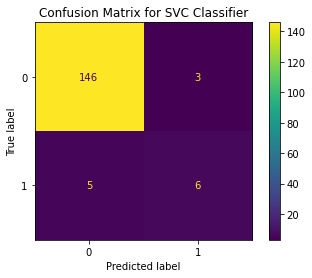

In [14]:
## region Implement ML: SVC

start = timer.time()

k_list = list()
f_1 = list()
parameters = list()

# Iterate through number of features (dimensions):
for k in range(35,36):
    df_train_fs = X_train[:]

    print(f"Applying SFS with {k} dimensions")
    # Apply sequential feature selection keeping k dimensions:
    rdg_cls = RidgeClassifier(class_weight='balanced')
    sfs = SequentialFeatureSelector(rdg_cls, n_features_to_select=k, scoring='f1')
    sfs.fit(df_train_fs, np.array(label_train).ravel())

    # Apply to test and train:
    df_train_fs = sfs.transform(df_train_fs)
    df_train_fs = pd.DataFrame(df_train_fs, columns=sfs.get_feature_names_out())

    # For each dimension k, do a grid search over the best parameters of the SVC regressor:
    params = [
        {'standardscaler': ['passthrough', StandardScaler()],
         'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['rbf'], 'svc__gamma': [0.001, 0.0001],
         'svc__class_weight': [None, 'balanced']},
        {'standardscaler': ['passthrough', StandardScaler(), MinMaxScaler()],
         'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear'], 'svc__class_weight': [None, 'balanced']}
    ]

    pipe = make_pipeline(StandardScaler(), SVC())
    gs = GridSearchCV(pipe, params, scoring='f1')
    gs.fit(df_train_fs, np.array(label_train).ravel())

    # Store best f1 score for each dimension k:
    k_list.append(k)
    f_1.append(gs.best_score_)
    parameters.append(gs.best_params_)

best_dim = k_list[np.array(f_1).argmax()]  # Retrieve best dimension
best_params = parameters[np.array(f_1).argmax()]  # Retrieve best parameters

print(f'The optimal number of dimension is {best_dim} with'
      f' an F1 score of {np.round(np.array(f_1).max(), 3)}'
      f' with parameters {best_params}')

end = timer.time()

print(f'Elapsed time is {end - start} seconds')

# Train with optimal parameters and dimensions:

if best_params['svc__kernel'] == 'linear':
    pipe = make_pipeline(SequentialFeatureSelector(rdg_cls, n_features_to_select=best_dim, scoring='f1'),
                         SVC(C=best_params['svc__C'], kernel=best_params['svc__kernel'],
                             class_weight=best_params['svc__class_weight']))


if best_params['svc__kernel'] == 'rbf':
    pipe = make_pipeline(SequentialFeatureSelector(rdg_cls, n_features_to_select=best_dim, scoring='f1'),
                         SVC(C=best_params['svc__C'], kernel=best_params['svc__kernel'], gamma=best_params['svc__gamma'],
                             class_weight=best_params['svc__class_weight']))

# Fit model:
pipe.fit(X_train, np.array(label_train).ravel())

# Evaluate on test set:
pred = pipe.predict(X_test)
f1_score = metrics.f1_score(np.array(label_test), pred)
acc = metrics.accuracy_score(np.array(label_test), pred)
print(f'The F1 score on the test set is {f1_score} and the accuracy is {acc}')

# Confusion matrix:
cm = metrics.confusion_matrix(np.array(label_test), pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix for SVC Classifier")
plt.show()

# endregion

### Currently the model only achieves an F1 score of .6 on the test set with an accuracy of 95%. I am thinking the following steps can help:

* We need more data, we only have 3 subjects.
* The data is very imbalanced (only 6% are ones)
* We can try to reduce motion [Not sure how, as I have not seen the setup]